Netflix wants to identify similar movies based on movie characteristics.

https://www.kaggle.com/shivamb/netflix-shows

In [209]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import umap
import sklearn
from collections import Counter
from wordcloud import WordCloud
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

# Display preference
warnings.filterwarnings('ignore')
pd.set_option('Display.max_columns', 500)
pd.set_option('Display.max_rows', 10000)

In [210]:
netflix = pd.read_csv('../../data/netflix_titles.csv')

## Exploratory Data Analysis (EDA) 

In [211]:
# Initial info
netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 12 columns):
show_id         6234 non-null int64
type            6234 non-null object
title           6234 non-null object
director        4265 non-null object
cast            5664 non-null object
country         5758 non-null object
date_added      6223 non-null object
release_year    6234 non-null int64
rating          6224 non-null object
duration        6234 non-null object
listed_in       6234 non-null object
description     6234 non-null object
dtypes: int64(2), object(10)
memory usage: 584.6+ KB


In [212]:
netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


I decided to remove ```netflix['show_id']``` due to its irrelevance and ```netflix['director']``` due to the number of missing values present.

In [213]:
netflix = netflix.drop(['show_id', 'director'], axis=1)
netflix = netflix.dropna(subset=['cast', 'date_added'])

For ```netflix['country']``` and ```netflix['rating']```, missing values were filled with the new value 'Unknown'.

In [214]:
netflix['country'] = netflix['country'].fillna('Unknown')
netflix['rating'] = netflix['rating'].fillna('Unknown')

In ```netflix['description']```, commas were replaced with whitespace to prepare it for later use.

In [215]:
netflix['description'] = netflix['description'].str.replace(',', ' ')

I converted ```netflix['date_added']``` to an ```int``` datatype.

In [216]:
for date in zip(netflix['date_added'].index, netflix['date_added']):
    netflix['date_added'][date[0]] = date[1][-4:]
    
netflix['date_added'] = netflix['date_added'].astype('int64')

### Show Type

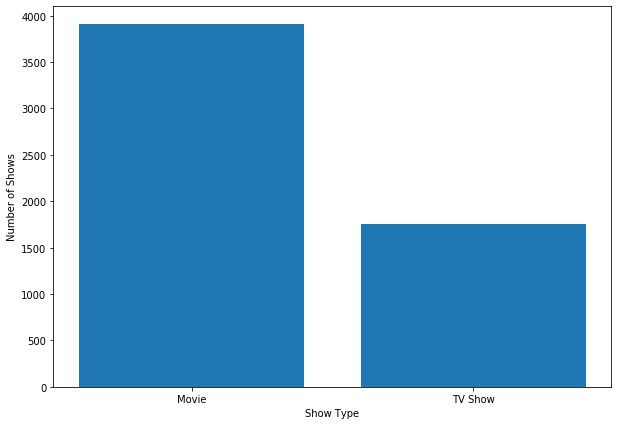

In [217]:
plt.figure(figsize=(10, 7))
plt.bar(netflix.groupby('type')['type'].count().index, netflix.groupby('type')['type'].count())
plt.ylabel('Number of Shows')
plt.xlabel('Show Type')
plt.show()

### Release Year 

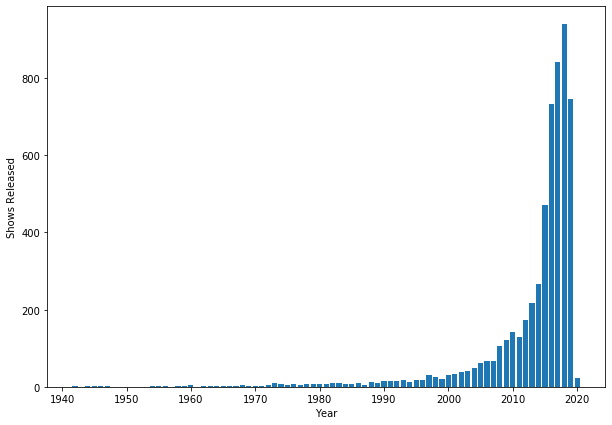

In [218]:
plt.figure(figsize=(10, 7))
plt.bar(netflix.groupby('release_year')['release_year'].count().index, 
        netflix.groupby('release_year')['release_year'].count())
plt.ylabel('Shows Released')
plt.xlabel('Year')
plt.show()

### Show Rating 

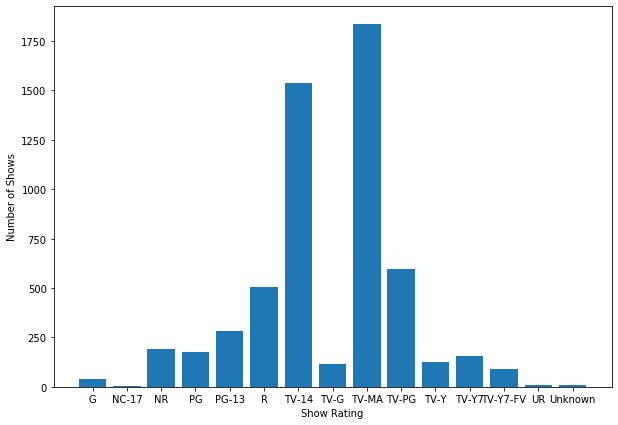

In [219]:
plt.figure(figsize=(10, 7))
plt.bar(netflix.groupby('rating')['rating'].count().index, 
        netflix.groupby('rating')['rating'].count())
plt.ylabel('Number of Shows')
plt.xlabel('Show Rating')
plt.show()

### Creation of Show Category Columns

In [220]:
# Create netflix column labels for show categories
show_categories = set()

for show_category in netflix['listed_in']:
    
    # Create list of show categories
    categories = show_category.split(',')
    
    # Add category to set
    for category in categories:
        show_categories.add(category.strip().lower())

In [221]:
# Create new netflix column labels
for show_category in sorted(show_categories):
    
    # Assign initial value
    netflix[show_category] = False

In [222]:
# Retrieve index for description and tv thrillers
description_index = netflix.columns.tolist().index('description')
tv_thriller_index = netflix.columns.tolist().index('tv thrillers')

# Column list
netflix_show_columns = netflix.columns[(description_index + 1):(tv_thriller_index + 1)].tolist()

In [223]:
for show_category in zip(netflix['listed_in'].index, netflix['listed_in']):
    
    # Create list of show categories
    categories = show_category[1].split(',')
    
    for category in categories:
        
        # Remove whitespace and set to lowercase
        category = category.strip().lower()
        
        # Show category in netflix columns
        if category in netflix_show_columns:
            
            # Update show category value to True
            netflix[category][show_category[0]] = True

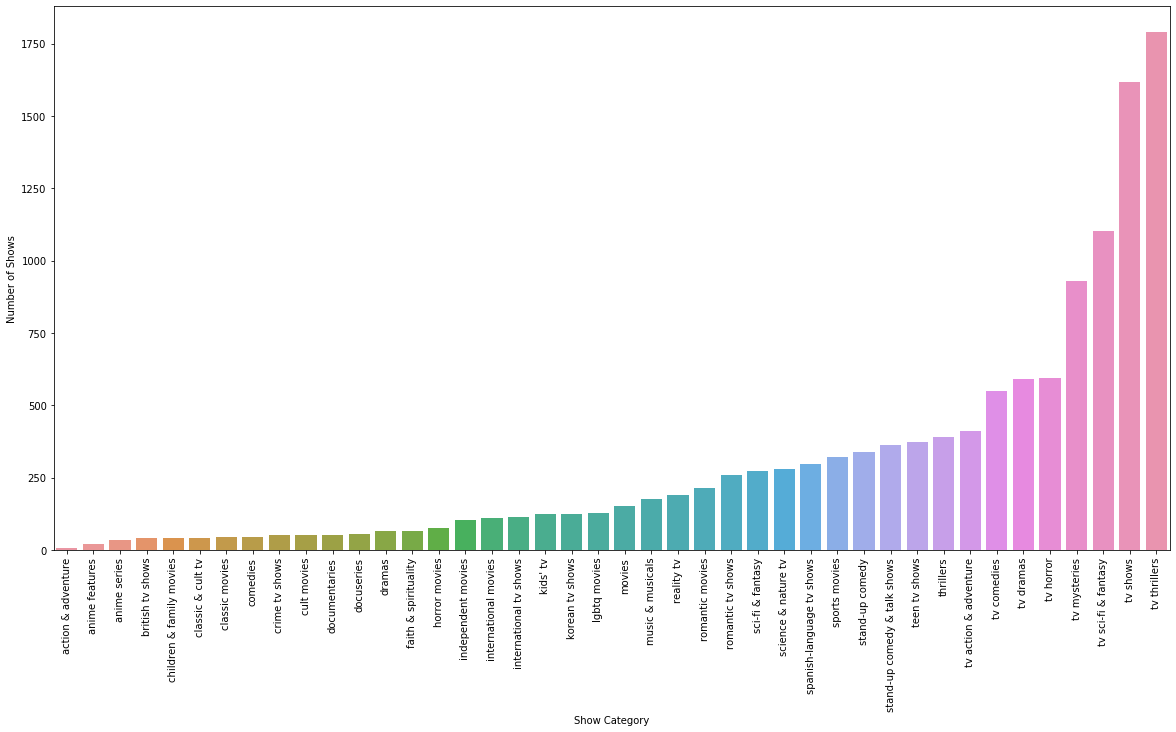

In [224]:
plt.figure(figsize=(20, 10))
sns.barplot(x=netflix_show_columns, y=netflix[netflix_show_columns].sum().sort_values())
plt.ylabel('Number of Shows')
plt.xlabel('Show Category')
plt.xticks(rotation=90)
plt.show()

### Creation of Country Columns

In [225]:
# Create netflix column labels for countries
countries = set()

for country in netflix['country']:
  
    # Create list for show countries
    show_countries = country.split(',')

    # Remove empty string
    if '' in show_countries:
        show_countries.remove('')
    
    # Add show country to countries set
    for show_country in show_countries:
        countries.add(show_country.strip().lower())

In [226]:
# Create new netflix country labels
for country in sorted(countries):
    
    # Assign initial value
    netflix[country] = False

In [227]:
# Retrieve column index for tv thrillers and west germany
tv_thriller_index = netflix.columns.tolist().index('tv thrillers')
west_germany_index = netflix.columns.tolist().index('west germany')

# Column list
netflix_country_columns = netflix.columns[(tv_thriller_index + 1):(west_germany_index + 1)].tolist()

In [228]:
for country in zip(netflix['country'].index, netflix['country']):
    
    # Create list of show countries
    show_countries = country[1].split(',')
    
    for show_country in show_countries:
        
        # Remove whitespace and set to lowercase
        show_country = show_country.strip().lower()
        
        # Show country in netflix columns
        if show_country in netflix_country_columns:
            
            # Update show category value to True
            netflix[show_country][country[0]] = True

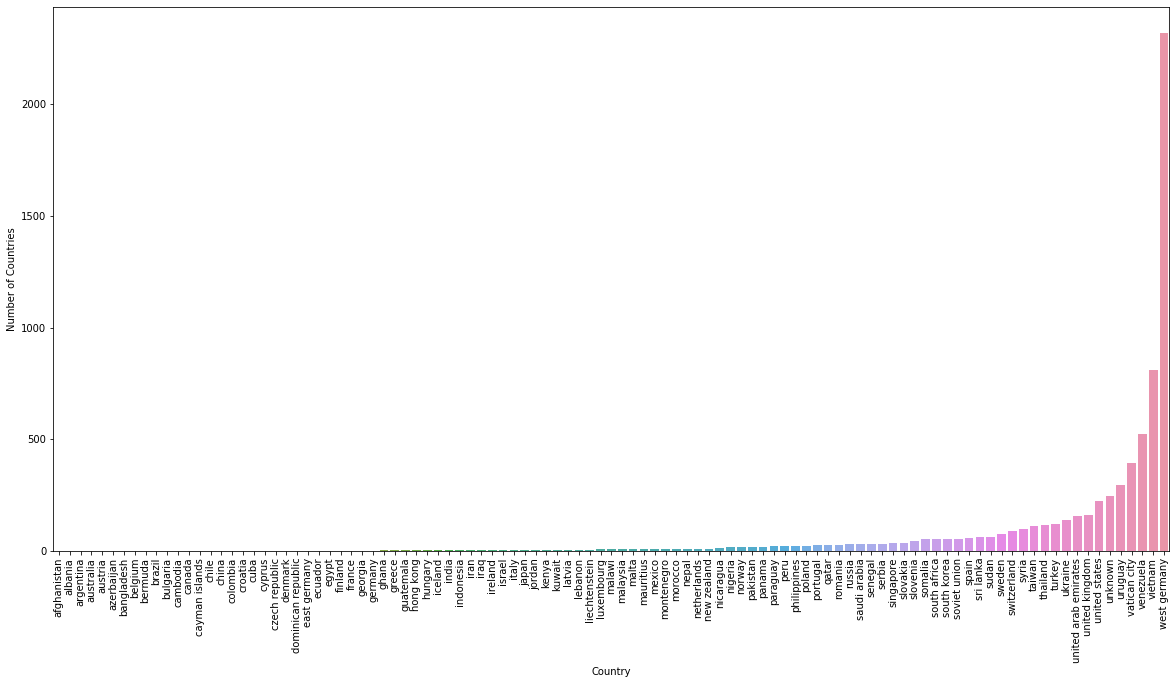

In [229]:
plt.figure(figsize=(20, 10))
sns.barplot(x=netflix_country_columns, y=netflix[netflix_country_columns].sum().sort_values())
plt.ylabel('Number of Countries')
plt.xlabel('Country')
plt.xticks(rotation=90)
plt.show()

### Creation of Keyword Columns

In [230]:
for column in netflix_show_columns:
    
    # Empty string
    column_words = ''
    
    # String to capture all words associated with show category
    for desc in netflix[netflix[column]]['description']:
        column_words += desc
        
    # Create WordCloud object
    wc = WordCloud().generate(column_words)
    
    # Create list of most frequent words
    column_keywords = [keyword for keyword in wc.words_.keys()]
    
    # Create new columns for the top 10 words
    for column_keyword in column_keywords[:10]:
        column_keyword = column_keyword.strip().lower()
        netflix[column_keyword] = False

In [231]:
# Retrieve column index for tv thrillers and west germany
west_germany_index = netflix.columns.tolist().index('west germany')
last_keyword_index = netflix.columns.tolist().index('brother')

# Column list
netflix_keyword_columns = netflix.columns[(west_germany_index + 1):(last_keyword_index + 1)].tolist()

In [232]:
for description in zip(netflix['description'].index, netflix['description']):
    
    # Create list of show description
    show_description = description[1].split(' ')
    
    for desc in show_description:
        
        # Remove whitespace and set to lowercase
        desc = desc.strip().lower()
        
        # Show description in netflix columns
        if desc in netflix_keyword_columns:
            
            # Update show category value to True
            netflix[desc][description[0]] = True

### Creation of Lead Role Columns

In [233]:
netflix_cast = set()

for column in netflix_show_columns:
    
    # Empty list
    column_cast = list()
    
    # String to capture all words associated with show category
    for cast in netflix[netflix[column]]['cast']:
        cast = cast.split(',')
        column_cast += cast

    word_cloud_dict = Counter(column_cast)
        
    # Create WordCloud object
    wc = WordCloud().generate_from_frequencies(word_cloud_dict)

    # Add value to set if greater than equal to 0.4
    for key, value in wc.words_.items():
        if value >= 0.5:
            netflix_cast.add(key.strip().lower())

In [234]:
# Create new columns for the to 10 words
for column_cast in netflix_cast:
    netflix[column_cast] = False

In [235]:
# Retrieve column index for tv thrillers and west germany
last_keyword_index = netflix.columns.tolist().index('brother')

# Column list
netflix_cast_columns = netflix.columns[(last_keyword_index + 1):].tolist()

In [236]:
for show_cast in zip(netflix['cast'].index, netflix['cast']):
    
    # Create list of show cast
    cast_members = show_cast[1].split(',')

    for cast in cast_members:
        
        # Remove whitespace and set to lowercase
        cast = cast.strip().lower()
        
        # Show cast in netflix columns
        if cast in netflix_cast_columns:
            
            # Update show cast value to True
            netflix[cast][show_cast[0]] = True

### Last Steps for EDA 

In [237]:
# One-hot encoding
netflix = pd.concat([netflix, pd.get_dummies(netflix['type'], drop_first=True)], axis=1)
netflix = pd.concat([netflix, pd.get_dummies(netflix['rating'], drop_first=True)], axis=1)

In [238]:
# Remove columns that have been transformed
netflix = netflix.drop(['type', 'title', 'cast', 'country', 'rating', 'duration', 'listed_in', 'description'], axis=1)

In [239]:
# Final look at dataset before moving forward
netflix.head()

,date_added,release_year,action & adventure,anime features,anime series,british tv shows,children & family movies,classic & cult tv,classic movies,comedies,crime tv shows,cult movies,documentaries,docuseries,dramas,faith & spirituality,horror movies,independent movies,international movies,international tv shows,kids' tv,korean tv shows,lgbtq movies,movies,music & musicals,reality tv,romantic movies,romantic tv shows,sci-fi & fantasy,science & nature tv,spanish-language tv shows,sports movies,stand-up comedy,stand-up comedy & talk shows,teen tv shows,thrillers,tv action & adventure,tv comedies,tv dramas,tv horror,tv mysteries,tv sci-fi & fantasy,tv shows,tv thrillers,afghanistan,albania,argentina,australia,austria,azerbaijan,bangladesh,belgium,bermuda,brazil,bulgaria,cambodia,canada,cayman islands,chile,china,colombia,croatia,cuba,cyprus,czech republic,denmark,dominican republic,east germany,ecuador,egypt,finland,france,georgia,germany,ghana,greece,guatemala,hong kong,hungary,iceland,india,indonesia,iran,iraq,ireland,israel,italy,japan,jordan,kenya,kuwait,latvia,lebanon,liechtenstein,luxembourg,malawi,malaysia,malta,mauritius,mexico,montenegro,morocco,nepal,netherlands,new zealand,nicaragua,nigeria,norway,pakistan,panama,paraguay,peru,philippines,poland,portugal,qatar,romania,russia,saudi arabia,senegal,serbia,singapore,slovakia,slovenia,somalia,south africa,south korea,soviet union,spain,sri lanka,sudan,sweden,switzerland,syria,taiwan,thailand,turkey,ukraine,united arab emirates,united kingdom,united states,unknown,uruguay,vatican city,venezuela,vietnam,west germany,must,find,two,take,life,cop,young,help,agent,team,ninja,naruto,year,demon,save,group,world,guts,student,mysterious,girl,force,fight,new,friend,series,london,crime,home,family,animal,christmas,make,british,run,town,character,years,returns,woman,war,teen,american,man,love,detective,murder,police,takes,killer,three,day,one,live,plan,documentary,film,explore,career,history,documentary series,travel,stories,father,word,story,faith,god,former,begin,house,horror,turn,adventure,evil,fun,korea,gay,pocoyo,holiday,star,true,musical,music,band,fall,host,compete,show,pop,prize,relationship,romance,earth,discover,human,planet,natural,creature,survive,inside,drug,sport,...,sébastien chassagne,karima gouit,ross duffer,verónika moral,herjunot ali,saúl lisazo,maría josé vargas,jesse williams,maxwell powers,robert ridgely,katelijne damen,juan pablo llano,jay baruchel,theo rossi,eric idle,devery jacobs,michael vlamis,tress macneille,lluís homar,eric balfour,alanna masterson,zoie palmer,phutharit prombandal,césar mora,christian rubeck,chris thys,kenneth mitchell,jean-christophe folly,joe cole,dylan minnette,louis herthum,david wenham,mike smith,jaime winstone,sherilyn fenn,kim ji-seok,ian mckellen,so-yeong lee,jesseca liu,elvira mínguez,jim gaffigan,belén cuesta,satoshi hino,claudia placer,lai wei,fernanda castillo,asia ortega,dustin milligan,frank langella,lady gaga,tony genaro,colm feore,kazuhiko inoue,kelly lua,steve tientcheu,suresh oberoi,lynn collins,kopi lim guo wei,donna duplantier,megan lai,bradley cooper,trevante rhodes,john hurt,kikuko inoue,mandy wei,nicholas hoult,yuji kondo,um apasiri nitibhon,margaret cho,woo do‑hwan,lin he-xuan,chutavuth pattarakampol,saba zaidi abdi,pavadee komchokpaisan,shea whigham,steve zahn,roger casamajor,keiko agena,paresh rawal,ye-jin lim,charles napier,john michael higgins,avishma lohith,ragini khanna,kim mee-kyeong,gustine fudickar,cory bowles,tinnu anand,akshay kumar,javier rey,ian james corlett,karamo brown,álvaro cervantes,charlie sheen,ronnie clark,kandyse mcclure,sarah stern,ahna o'reilly,jeon seok-ho,eka darville,nicolas cage,brian drummond,genesis rodriguez,hana shiha,mohamed mamdouh,ana wagener,mohammed hafiz,greg bryk,roberto mateos,tatchapol thitiapichai,sam jay,jack nance,michael benyaer,rana daggubati,wilmer valderrama,luisa merelas,lena headey,jared leto,yousra,matthew broderick,bruce thomas,kaito ishikawa,nicholas colasanto,rober

In [240]:
print('Number of rows is {}'.format(netflix.shape[0]))
print('Number of columns is {}'.format(netflix.shape[1]))

Number of rows is 5654
Number of columns is 2506


In [241]:
# Create feature dataframe
X = netflix.copy()

# Standardize data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Transpose X
Xt = X_std.T

# Covariance
Cx = np.cov(Xt)

# Calculate eigenvalues and eigenvectors
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

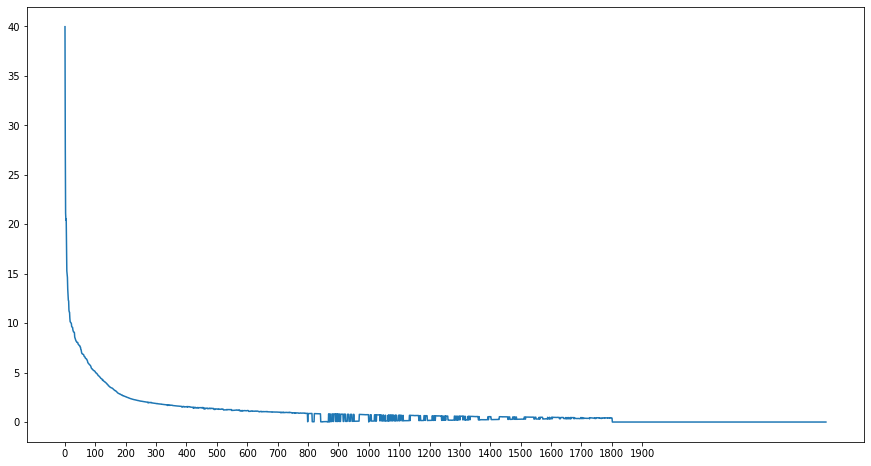

In [242]:
# Print scree plot
plt.figure(figsize=(15, 8))
plt.plot(eig_val_cov)
plt.xticks(np.arange(0, 2000, step=100))
plt.show()

In [243]:
# Dimensionality reduction using PCA
pca = PCA(n_components=200)
X_pca = pca.fit_transform(X_std)

## Algorithm Selection 

### Clustering 

I'll be comparing K-Means, Hierarchical, DBSCAN and Gaussian Mixture Models clustering algorithms.

### K-Means 

In [244]:
# Function for silhouette score
def score(X_standard, y_predictions):
    print('Silhouette Score is {}'.format(silhouette_score(X_standard, y_predictions, metric='euclidean')))

In [245]:
clusters = range(2, 51)

for cluster in clusters:
    
    # Number of clusters
    print('Number of clusters: {}'.format(str(cluster)))
    
    # Define KMeans
    kmeans = KMeans(n_clusters=cluster, random_state=123)

    # Fit model
    kmeans.fit(X_pca)

    # Predictions
    kmeans_predictions = kmeans.predict(X_pca)
    
    # Metrics
    score(X_pca, kmeans_predictions)

Number of clusters: 2
Silhouette Score is 0.8977724089447398
Number of clusters: 3
Silhouette Score is 0.9375861346750014
Number of clusters: 4
Silhouette Score is 0.7358483782586249
Number of clusters: 5
Silhouette Score is 0.8889211826351927
Number of clusters: 6
Silhouette Score is 0.2625843658908811
Number of clusters: 7
Silhouette Score is 0.21807163411591157
Number of clusters: 8
Silhouette Score is 0.8776201844416567
Number of clusters: 9
Silhouette Score is 0.8772001305979062
Number of clusters: 10
Silhouette Score is 0.8778580679725431
Number of clusters: 11
Silhouette Score is 0.5953444640054206
Number of clusters: 12
Silhouette Score is 0.2160454353570761
Number of clusters: 13
Silhouette Score is 0.7688716129666544
Number of clusters: 14
Silhouette Score is 0.7567509075574714
Number of clusters: 15
Silhouette Score is 0.21775889674671192
Number of clusters: 16
Silhouette Score is 0.722054541150832
Number of clusters: 17
Silhouette Score is 0.7438239120838219
Number of clust

### Hierarchical

In [246]:
# Agglomerative clustering (complete)
complete_cosine = AgglomerativeClustering(linkage='complete', affinity='cosine')

# Fit and predictions
complete_cosine_predictions = complete_cosine.fit_predict(X_pca)

# Metrics
score(X_pca, complete_cosine_predictions)

Silhouette Score is -0.043182925822205113


In [247]:
# Agglomerative clustering (complete)
complete_manhattan = AgglomerativeClustering(linkage='complete', affinity='manhattan')

# Fit and predictions
complete_manhattan_predictions = complete_manhattan.fit_predict(X_pca)

# Metrics
score(X_pca, complete_manhattan_predictions)

Silhouette Score is 0.8111889375670307


In [248]:
# Agglomerative clustering (ward)
ward_cluster = AgglomerativeClustering(linkage='ward', affinity='euclidean')

# Fit and predictions
ward_predictions = ward_cluster.fit_predict(X_pca)

# Metrics
score(X_pca, ward_predictions)

Silhouette Score is 0.9477845834407596


In [249]:
# Agglomerative clustering (average)
average_cosine = AgglomerativeClustering(linkage='average', affinity='cosine')

# Fit and predictions
average_cosine_predictions = average_cosine.fit_predict(X_pca)

# Metrics
score(X_pca, average_cosine_predictions)

Silhouette Score is 0.10813930052584886


In [250]:
# Agglomerative clustering (average)
average_manhattan = AgglomerativeClustering(linkage='average', affinity='manhattan')

# Fit and predictions
average_manhattan_predictions = average_manhattan.fit_predict(X_pca)

# Metrics
score(X_pca, complete_manhattan_predictions)

Silhouette Score is 0.8111889375670307


### Density-based Spatial Clustering of Applications with Noise (DBSCAN) 

In [251]:
samples = range(2, 16)

for sample in samples:
    
    # Number of samples
    print('Number of samples: {}'.format(str(sample)))

    # Define DBSCAN
    dbscan = DBSCAN(eps=1, min_samples=sample)

    # Fit and predictions
    dbscan_predictions = dbscan.fit_predict(X_pca)
    
    score(X_pca, dbscan_predictions)

Number of samples: 2
Silhouette Score is -0.5612176447581333
Number of samples: 3
Silhouette Score is -0.5775823793029329
Number of samples: 4
Silhouette Score is -0.5870802938521823
Number of samples: 5
Silhouette Score is -0.5909540256049323
Number of samples: 6
Silhouette Score is -0.5924749135607243
Number of samples: 7
Silhouette Score is -0.5917877479771851
Number of samples: 8
Silhouette Score is -0.58688269865764
Number of samples: 9
Silhouette Score is -0.5872335038996803
Number of samples: 10
Silhouette Score is -0.5857439379188187
Number of samples: 11
Silhouette Score is -0.586007684468478
Number of samples: 12
Silhouette Score is -0.5810696671415475
Number of samples: 13
Silhouette Score is -0.5813910889123931
Number of samples: 14
Silhouette Score is -0.5813910889123931
Number of samples: 15
Silhouette Score is -0.5826177764080965


In [252]:
samples = range(2, 11)

for sample in samples:
    
    # Number of samples
    print('Number of samples: {}'.format(str(sample)))

    # Define DBSCAN
    dbscan = DBSCAN(eps=2, min_samples=sample)

    # Fit and predictions
    dbscan_predictions = dbscan.fit_predict(X_pca)
    
    score(X_pca, dbscan_predictions)

Number of samples: 2
Silhouette Score is -0.45516541368417635
Number of samples: 3
Silhouette Score is -0.4388334555782645
Number of samples: 4
Silhouette Score is -0.4301860324952531
Number of samples: 5
Silhouette Score is -0.4195745297308929
Number of samples: 6
Silhouette Score is -0.40927558393067043
Number of samples: 7
Silhouette Score is -0.35903982406794177
Number of samples: 8
Silhouette Score is -0.358940449393945
Number of samples: 9
Silhouette Score is -0.35948646130939327
Number of samples: 10
Silhouette Score is -0.3610592939988877
Number of samples: 11
Silhouette Score is -0.37171054882002713
Number of samples: 12
Silhouette Score is -0.37525830023230916
Number of samples: 13
Silhouette Score is -0.36949504777560155
Number of samples: 14
Silhouette Score is -0.3483401617339727
Number of samples: 15
Silhouette Score is -0.34890429635542763


In [253]:
samples = range(2, 11)

for sample in samples:
    
    # Number of samples
    print('Number of samples: {}'.format(str(sample)))

    # Define DBSCAN
    dbscan = DBSCAN(eps=4, min_samples=sample)

    # Fit and predictions
    dbscan_predictions = dbscan.fit_predict(X_pca)
    
    score(X_pca, dbscan_predictions)

Number of samples: 2
Silhouette Score is -0.17061337064809917
Number of samples: 3
Silhouette Score is -0.14731063820952928
Number of samples: 4
Silhouette Score is -0.12487462507478458
Number of samples: 5
Silhouette Score is -0.13439877638852882
Number of samples: 6
Silhouette Score is -0.12737480187019126
Number of samples: 7
Silhouette Score is -0.12986199462080214
Number of samples: 8
Silhouette Score is -0.1294545118314983
Number of samples: 9
Silhouette Score is -0.12990594659241078
Number of samples: 10
Silhouette Score is -0.10759354529207006


In [254]:
samples = range(2, 11)

for sample in samples:
    
    # Number of samples
    print('Number of samples: {}'.format(str(sample)))

    # Define DBSCAN
    dbscan = DBSCAN(eps=6, min_samples=sample)

    # Fit and predictions
    dbscan_predictions = dbscan.fit_predict(X_pca)
    
    score(X_pca, dbscan_predictions)

Number of samples: 2
Silhouette Score is 0.06330477219700117
Number of samples: 3
Silhouette Score is 0.037728697578160934
Number of samples: 4
Silhouette Score is 0.044537338110918076
Number of samples: 5
Silhouette Score is 0.06982897782146257
Number of samples: 6
Silhouette Score is 0.06633698958569936
Number of samples: 7
Silhouette Score is 0.0655931244130577
Number of samples: 8
Silhouette Score is 0.10479440501651224
Number of samples: 9
Silhouette Score is 0.1035840937936065
Number of samples: 10
Silhouette Score is 0.1013910498477237


In [255]:
samples = range(2, 11)

for sample in samples:
    
    # Number of samples
    print('Number of samples: {}'.format(str(sample)))

    # Define DBSCAN
    dbscan = DBSCAN(eps=8, min_samples=sample)

    # Fit and predictions
    dbscan_predictions = dbscan.fit_predict(X_pca)
    
    score(X_pca, dbscan_predictions)

Number of samples: 2
Silhouette Score is 0.1517355671290821
Number of samples: 3
Silhouette Score is 0.14954698192624005
Number of samples: 4
Silhouette Score is 0.17722775467690843
Number of samples: 5
Silhouette Score is 0.1704131765678574
Number of samples: 6
Silhouette Score is 0.2085275926421108
Number of samples: 7
Silhouette Score is 0.3545707742455259
Number of samples: 8
Silhouette Score is 0.28018467880923914
Number of samples: 9
Silhouette Score is 0.5334781298437307
Number of samples: 10
Silhouette Score is 0.5329192782686384


In [256]:
samples = range(2, 11)

for sample in samples:
    
    # Number of samples
    print('Number of samples: {}'.format(str(sample)))

    # Define DBSCAN
    dbscan = DBSCAN(eps=10, min_samples=sample)

    # Fit and predictions
    dbscan_predictions = dbscan.fit_predict(X_pca)
    
    score(X_pca, dbscan_predictions)

Number of samples: 2
Silhouette Score is 0.235430415901568
Number of samples: 3
Silhouette Score is 0.22263370478662947
Number of samples: 4
Silhouette Score is 0.21523336344248248
Number of samples: 5
Silhouette Score is 0.27091063247098096
Number of samples: 6
Silhouette Score is 0.5800429399462819
Number of samples: 7
Silhouette Score is 0.5793948816747303
Number of samples: 8
Silhouette Score is 0.5392776736415015
Number of samples: 9
Silhouette Score is 0.5933302485739748
Number of samples: 10
Silhouette Score is 0.5914454462282184


In [257]:
samples = range(2, 11)

for sample in samples:
    
    # Number of samples
    print('Number of samples: {}'.format(str(sample)))

    # Define DBSCAN
    dbscan = DBSCAN(eps=12, min_samples=sample)

    # Fit and predictions
    dbscan_predictions = dbscan.fit_predict(X_pca)
    
    score(X_pca, dbscan_predictions)

Number of samples: 2
Silhouette Score is 0.28740501248413136
Number of samples: 3
Silhouette Score is 0.3218810249705054
Number of samples: 4
Silhouette Score is 0.3831904696373177
Number of samples: 5
Silhouette Score is 0.3883125782469334
Number of samples: 6
Silhouette Score is 0.6101210420045394
Number of samples: 7
Silhouette Score is 0.6064619795168472
Number of samples: 8
Silhouette Score is 0.6036033578845473
Number of samples: 9
Silhouette Score is 0.5999728206140854
Number of samples: 10
Silhouette Score is 0.6271426114333832


In [258]:
samples = range(2, 11)

for sample in samples:
    
    # Number of samples
    print('Number of samples: {}'.format(str(sample)))

    # Define DBSCAN
    dbscan = DBSCAN(eps=14, min_samples=sample)

    # Fit and predictions
    dbscan_predictions = dbscan.fit_predict(X_pca)
    
    score(X_pca, dbscan_predictions)

Number of samples: 2
Silhouette Score is 0.3339933441039028
Number of samples: 3
Silhouette Score is 0.3227457466658224
Number of samples: 4
Silhouette Score is 0.666186878395796
Number of samples: 5
Silhouette Score is 0.6626688574933961
Number of samples: 6
Silhouette Score is 0.6609987606570518
Number of samples: 7
Silhouette Score is 0.6583562183234587
Number of samples: 8
Silhouette Score is 0.6567917000133745
Number of samples: 9
Silhouette Score is 0.6275216553882118
Number of samples: 10
Silhouette Score is 0.6521930114515903


### Gaussian Mixture Models (GMM)

In [259]:
components = range(2, 16)

for component in components:
    
    # Number of components
    print('Number of components: {}'.format(str(component)))

    # Define GMM
    gmm = GaussianMixture(n_components=component, random_state=123)

    # Fit and predictions
    gmm_predictions = gmm.fit_predict(X_pca)
    
    score(X_pca, gmm_predictions)

Number of components: 2
Silhouette Score is 0.8772095413483346
Number of components: 3
Silhouette Score is 0.8662883015181896
Number of components: 4
Silhouette Score is 0.8666447183956939
Number of components: 5
Silhouette Score is 0.8668647932463461
Number of components: 6
Silhouette Score is 0.8670094358568894
Number of components: 7
Silhouette Score is 0.8673050929612255
Number of components: 8
Silhouette Score is 0.6951881705458955
Number of components: 9
Silhouette Score is 0.6872037440370694
Number of components: 10
Silhouette Score is 0.6880392292146114
Number of components: 11
Silhouette Score is 0.6883268835187911
Number of components: 12
Silhouette Score is 0.6887264475083728
Number of components: 13
Silhouette Score is 0.6898996374706332
Number of components: 14
Silhouette Score is 0.690491272462164
Number of components: 15
Silhouette Score is 0.6853505449561541


### Dimensionality Reduction 

I'll be comparing t-SNE and UMAP dimensionality reduction techniques.

### t-Distributed Stochastic Neighbor Embedding (t-SNE)

Number of iteration: 250
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.156s...
[t-SNE] Computed neighbors for 5654 samples in 34.380s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.304030
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.790894
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299

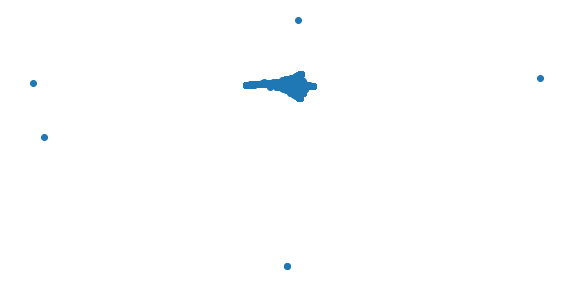

Number of iteration: 275
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.186s...
[t-SNE] Computed neighbors for 5654 samples in 34.149s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.304030
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.841423
[t-SNE] KL divergence after 275 iterations: 2.622891


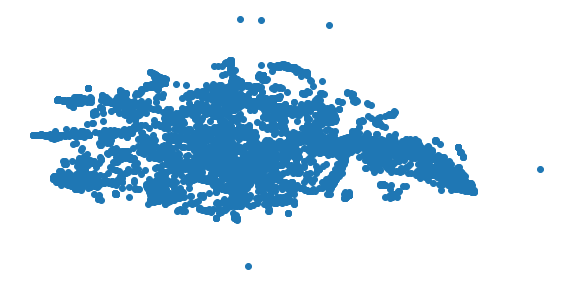

Number of iteration: 300
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.152s...
[t-SNE] Computed neighbors for 5654 samples in 34.325s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.304030
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.022820
[t-SNE] KL divergence after 300 iterations: 2.101415


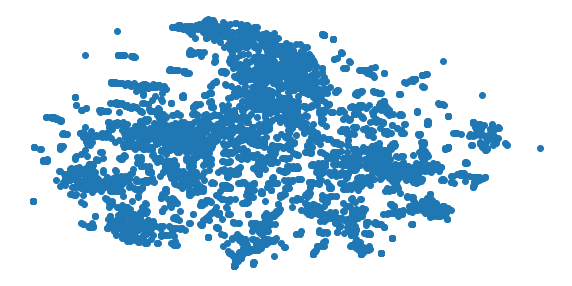

Number of iteration: 325
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.174s...
[t-SNE] Computed neighbors for 5654 samples in 33.657s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.304030
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.781067
[t-SNE] KL divergence after 325 iterations: 1.882252


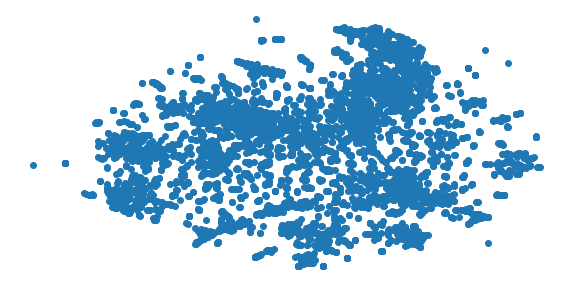

Number of iteration: 350
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.149s...
[t-SNE] Computed neighbors for 5654 samples in 35.288s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.304030
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.819138
[t-SNE] KL divergence after 350 iterations: 1.752223


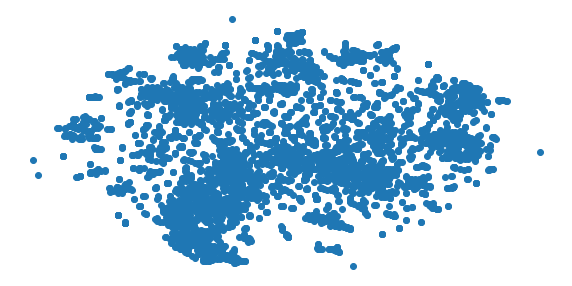

Number of iteration: 375
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.166s...
[t-SNE] Computed neighbors for 5654 samples in 34.492s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.304030
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.740898
[t-SNE] KL divergence after 375 iterations: 1.655017


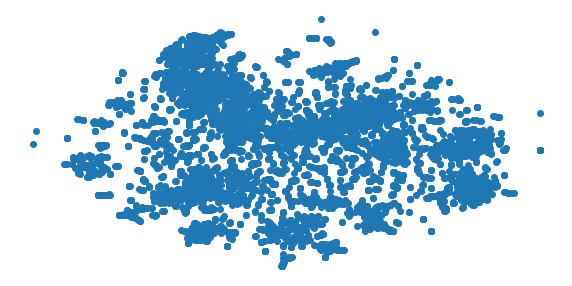

Number of iteration: 400
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.148s...
[t-SNE] Computed neighbors for 5654 samples in 34.043s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.304030
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.910355
[t-SNE] KL divergence after 400 iterations: 1.602708


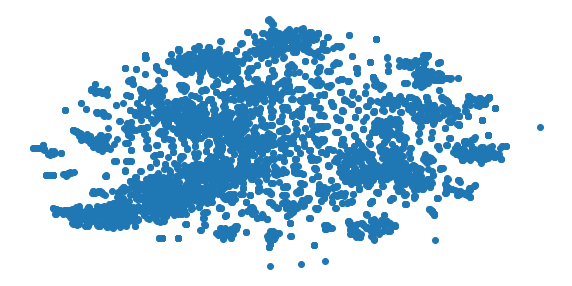

In [260]:
iterations = [250, 275, 300, 325, 350, 375, 400]

for iteration in iterations:
    
    # Number of iterations
    print('Number of iteration: {}'.format(str(iteration)))

    # Define t-SNE
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=iteration)

    # Retrieve components
    tsne_results = tsne.fit_transform(X_pca)
    
    # Plot visual
    plt.figure(figsize=(10,5))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

### Uniform Manifold Approximation and Projection (UMAP) 

Number of neighbors: 3


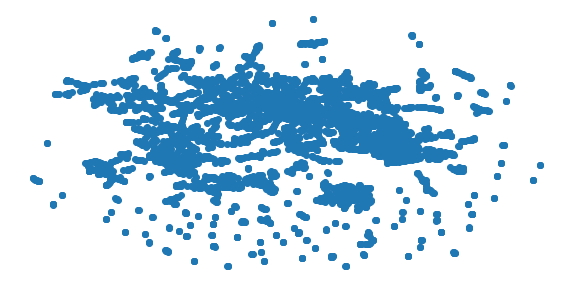

Number of neighbors: 4


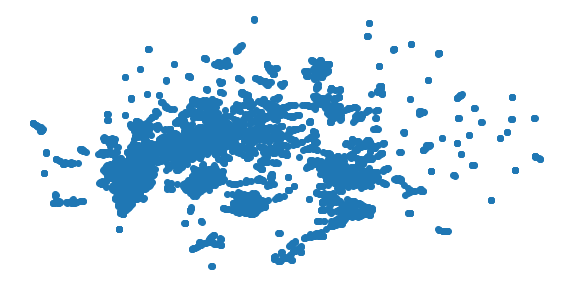

Number of neighbors: 5


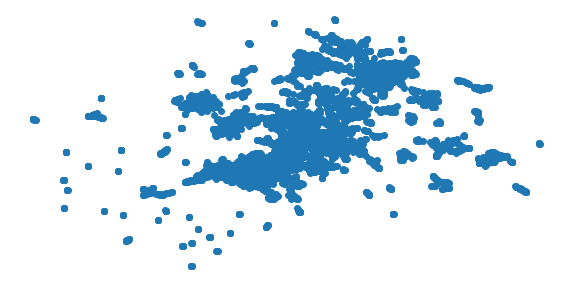

Number of neighbors: 6


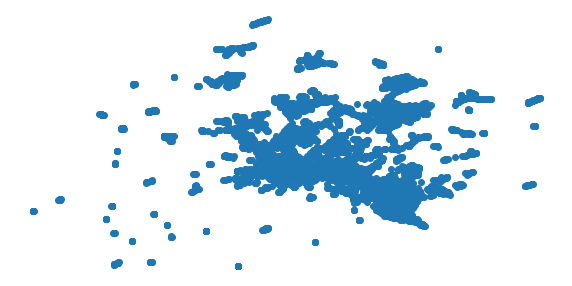

Number of neighbors: 7


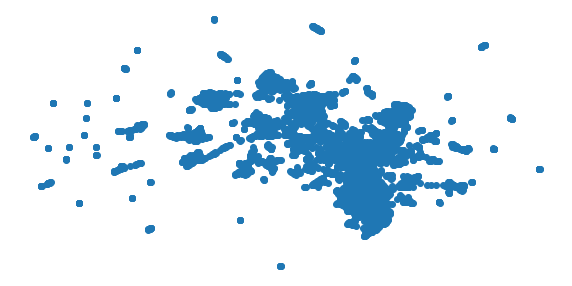

Number of neighbors: 8


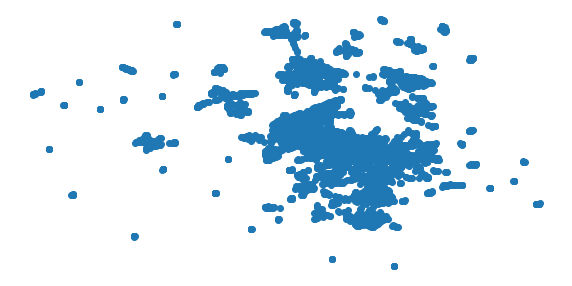

Number of neighbors: 9


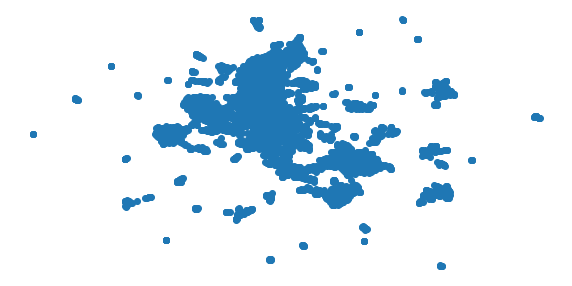

Number of neighbors: 10


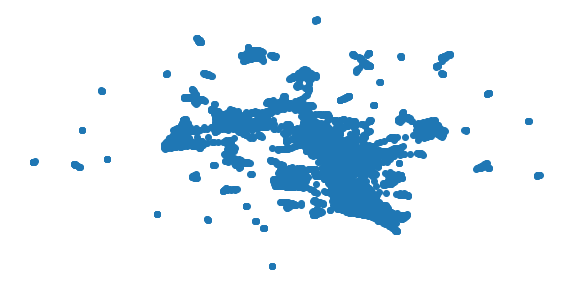

Number of neighbors: 11


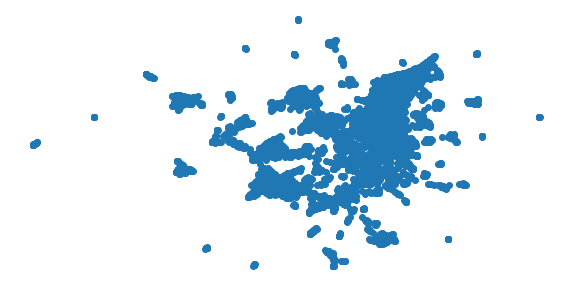

Number of neighbors: 12


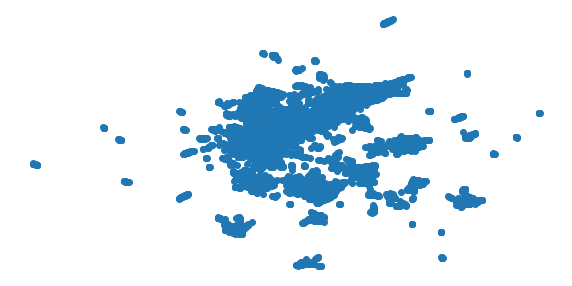

Number of neighbors: 13


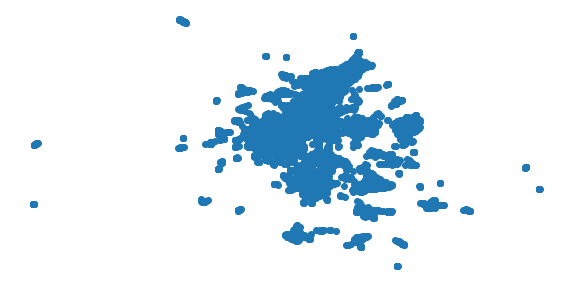

Number of neighbors: 14


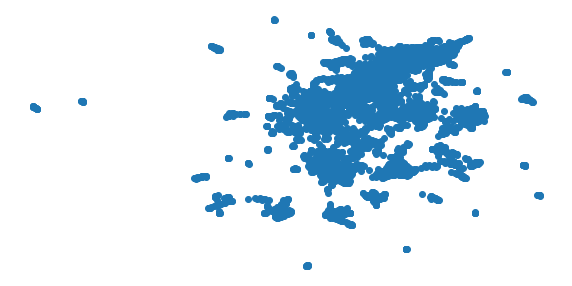

Number of neighbors: 15


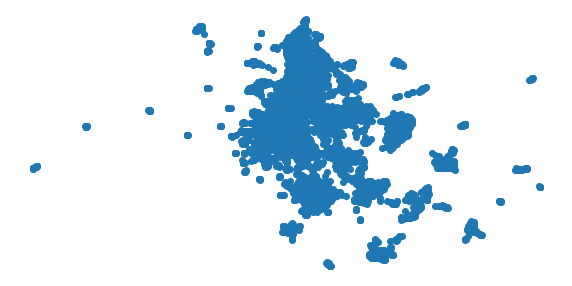

Number of neighbors: 16


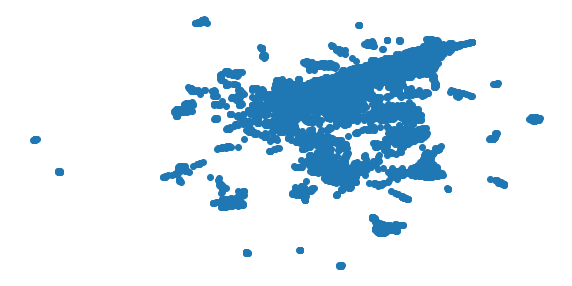

Number of neighbors: 17


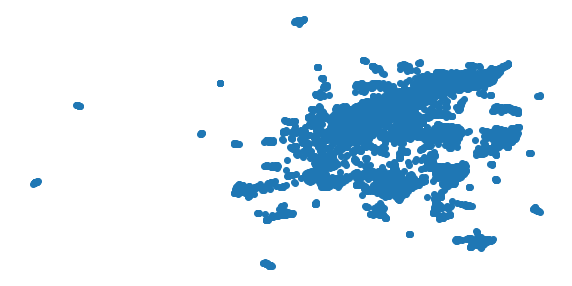

Number of neighbors: 18


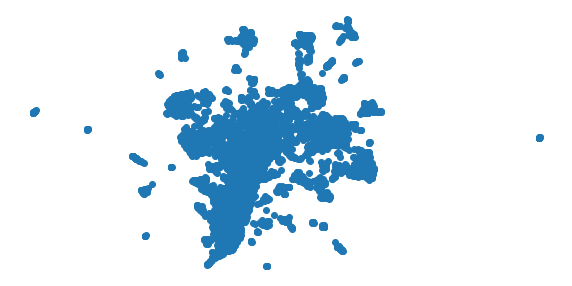

Number of neighbors: 19


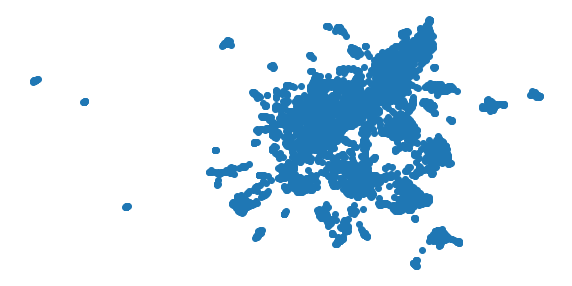

Number of neighbors: 20


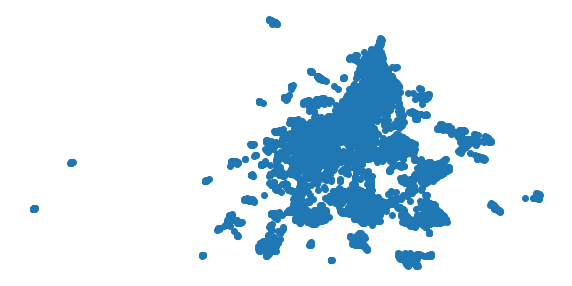

In [261]:
neighbors = range(3, 21)

for neighbor in neighbors:
    
    # Number of neighbors
    print('Number of neighbors: {}'.format(str(neighbor)))

    # Define UMAP
    umap_results = umap.UMAP(n_neighbors=neighbor,
                             min_dist=0.3,
                             metric='correlation').fit_transform(X_pca)
    
    # Plot visual
    plt.figure(figsize=(10,5))
    plt.scatter(umap_results[:, 0], umap_results[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()